### Notes

The Fauseweh-Zhu paper [here](https://arxiv.org/pdf/2112.04276).

Variational Quantum Design Course from IBMQ Learning
- [Ansatz](https://learning.quantum.ibm.com/course/variational-algorithm-design/ansatze-and-variational-forms) include the NLocal, we use TwoLocal (but i already wrote this)
- [Optimisation](https://learning.quantum.ibm.com/course/variational-algorithm-design/optimization-loops) frameworks have also been discussed
- Also check out [Quantum Approximate Optimization Algorithm](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)
- Relevant (exactly) is [VQD](https://learning.quantum.ibm.com/course/variational-algorithm-design/instances-and-extensions#vqds-implementation)

## Imports

In [1]:
!python3 --version
!pip freeze | grep qiskit
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal, UGate, PauliEvolutionGate
from qiskit.quantum_info import Statevector, SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.optimize import minimize

Python 3.10.6


'grep' is not recognized as an internal or external command,
operable program or batch file.


## Parameters

In [2]:
chain_length = 4

Ω = 2.5

omit_ratio = 0

In [3]:
num_layers = 2
periods = 1
num_time_steps = 150
dt = periods / num_time_steps * 2*np.pi/Ω
A = 0

In [4]:
cost_threshold = 1e-3

parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers
param_space = ParameterVector('θ', parameter_space_size)

parameter_space_size2 = 2 * chain_length * num_layers + (omit_ratio*chain_length)//2 + (((chain_length*(1-omit_ratio)))//2-1)
param_space2 = ParameterVector('θ', parameter_space_size2)

## Functions

#### Ansatz creator for spin chain

In [5]:
def create_ansatz_circuit(qc, num_layers=num_layers, param_space=param_space):
    param_counter = -1
    def ansatz_circuit_0(qc, param_space, param_counter=0):
        print('Number of params:',parameter_space_size)
        # layer 0
        # param_counter=0
        for i in range(qc.num_qubits):
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    def ansatz_circuit_1(qc, param_space, param_counter=0):
        # param_counter = 2 * chain_length
        for i in range(qc.num_qubits-1):
            qc.cx(i,i+1)
        qc.cx(-1,0)
        for i in range(qc.num_qubits):
            qc.rz(param_space[param_counter:=param_counter+1],i)
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    param_counter = ansatz_circuit_0(qc, param_space, param_counter)
    for i in range(num_layers):
        param_counter = ansatz_circuit_1(qc, param_space, param_counter)
    display(qc.draw('mpl'))

#### Ansatz creator for spin ladder

In [6]:
def ansatz_circuit_ladder(qc, param_space=param_space2, omit_ratio=omit_ratio):
    counter = -1
    def layer(qc, params, param_counter):
        for i in range(qc.num_qubits):
            qc.rx(params[param_counter:=param_counter+1],i)
            qc.rz(params[param_counter:=param_counter+1],i)
        return param_counter
    def entangle(qc, params, param_counter, double_entangle):
        for i in range(qc.num_qubits//2):
            qc.rzz(params[param_counter:=param_counter+1], 2*i, 2*i+1)
        if double_entangle:
            for i in range((qc.num_qubits-1)//2):
                qc.rzz(params[param_counter:=param_counter+1], 2*i+1, 2*i+2)
        return param_counter
    fra = Fraction(omit_ratio).limit_denominator()
    # print(fra)
    for layer_count in range(num_layers):
        counter = layer(qc, param_space, counter)
        counter = entangle(qc, param_space, counter, double_entangle=(layer_count%fra.denominator<fra.numerator))
        qc.barrier()
    display(qc.draw('mpl'))

#### System Definitions

In [7]:
def hamiltonian(t, A=2, J=1, Ω=Ω):
    creator = ['I']*chain_length
    paulis = ['I','X','Y','Z']
    ham = [] # [('X',1.0)]
    for i in range(chain_length-1):
        for j in range(1,4):
            op = creator[:]
            op[i] = paulis[j]
            op[i+1] = paulis[j]
            ham.append([''.join(op), -J/4])
    for i in range(chain_length):
        op1, op2 = creator[:], creator[:]
        op1[i] = 'X'
        op2[i] = 'Y'
        ham.append([''.join(op1), A * np.cos(Ω*t)])
        ham.append([''.join(op2), A * np.sin(Ω*t)])
    ham = np.array(ham)
    # print(A * np.cos(Ω*t))
    return SparsePauliOp(ham[:,0], ham[:,1])

def hamiltonian_linear(t, A, Δ=1, Ω=Ω):
    ham = SparsePauliOp(['Z','X'] , [-Δ/2, A/2/Ω*np.cos(Ω*t)])
    # plt.plot(t, A*np.cos(Ω*t)/2,'.')
    return ham

def unitary_time_evolver(ham, *args, num_qbits=chain_length, time=num_time_steps*dt, dt=dt):#num_steps=num_time_steps):

    circuit = QuantumCircuit(num_qbits)
    
    for i in range(1, num_time_steps+1):
        circuit.append(PauliEvolutionGate(ham(i*dt, *args), time=dt), range(num_qbits))

    # print('Unitary Evolution Circuit')
    # display(circuit.draw('mpl'))
    
    return circuit

#### Overlap

In [8]:
def overlap(circuit1, circuit2): # < circuit1 | circuit2 >
    circuit_state1 = Statevector.from_instruction(circuit1)
    circuit_state2 = Statevector.from_instruction(circuit2)
    return np.abs(circuit_state1.inner(circuit_state2))**2

#### Cost function

In [9]:
def cost_function(params, circuit, unitary_time_evolution, computed_circuits=[], λ=5):
    summation = 0
    # parameter_values = {param_space[i]: params[i] for i in range(params_size)}
    try:
        bc = circuit.assign_parameters(params)
    except Exception as e:
        print(e, 'in cost_function()')
        return 1
    if computed_circuits != []:
        summation = np.sum( [overlap(i, bc) for i in computed_circuits] )
    evolved = bc.compose(unitary_time_evolution)
    cost = overlap(bc, evolved) - λ * summation
    return (cost - 1)**2

def cost_func_vqe(params, ansatz, hamiltonian, estimator, **kwargs, computed_circuits=[], λ=5):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

#### Recursive optimiser (fatal)

In [10]:
def optimise(params, circuit, unitary_time_evolution, computed_circuits=[], optim_steps=0): # returns: circuit, cost
    def steps():
        print('optim_steps:', optim_steps)
    try:
        bc = circuit.assign_parameters(params)
    except Exception as e:
        print(e, 'in optimise()')
        return circuit, 0
    cost = cost_function(params, circuit, unitary_time_evolution, computed_circuits)

    if optim_steps==10:
        # raise RecursionError('Recursion limit reached!')
        print('Recursion limit reached!')
        return bc, cost
    
    if np.abs(cost-1) < cost_threshold:
        steps()
        # print('cost:',cost)
        return bc, cost

    ### optimiser 
    computed_circuits.append(bc)
    result = minimize(cost_function, params, args=(bc, unitary_time_evolution, computed_circuits), method='BFGS')
    print(result)
    
    ###
    # print(optim_steps)

    return optimise(result.x, circuit, unitary_time_evolution, computed_circuits, optim_steps=optim_steps+1)

## Main

### Linearly Driven

In [22]:
initial_guess = [1,1,1]

test_qc = QuantumCircuit(1)
params = ParameterVector('θ', len(initial_guess))
# print(*params)

### ansatz
test_qc.u(*params, 0)
display(test_qc.draw())
###

A = 1/Ω

unitary_timevo_circuit = unitary_time_evolver(hamiltonian_linear, A, num_qbits=1)

# evolved = test_qc.compose(unitary_timevo_circuit)
# print(len(initial_guess)==len(params))

result = minimize(cost_func_vqe, initial_guess, args=(test_qc, hamiltonian_linear), method='BFGS')

┌───────────────────┐
q: ┤ U(θ[0],θ[1],θ[2]) ├
   └───────────────────┘

In [23]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.835576216743084e-07
        x: [ 1.240e-02  9.733e-01  1.000e+00]
      nit: 5
      jac: [-8.112e-06  7.195e-07  0.000e+00]
 hess_inv: [[ 2.435e+02  2.174e+00  0.000e+00]
            [ 2.174e+00  1.019e+00  0.000e+00]
            [ 0.000e+00  0.000e+00  1.000e+00]]
     nfev: 32
     njev: 8

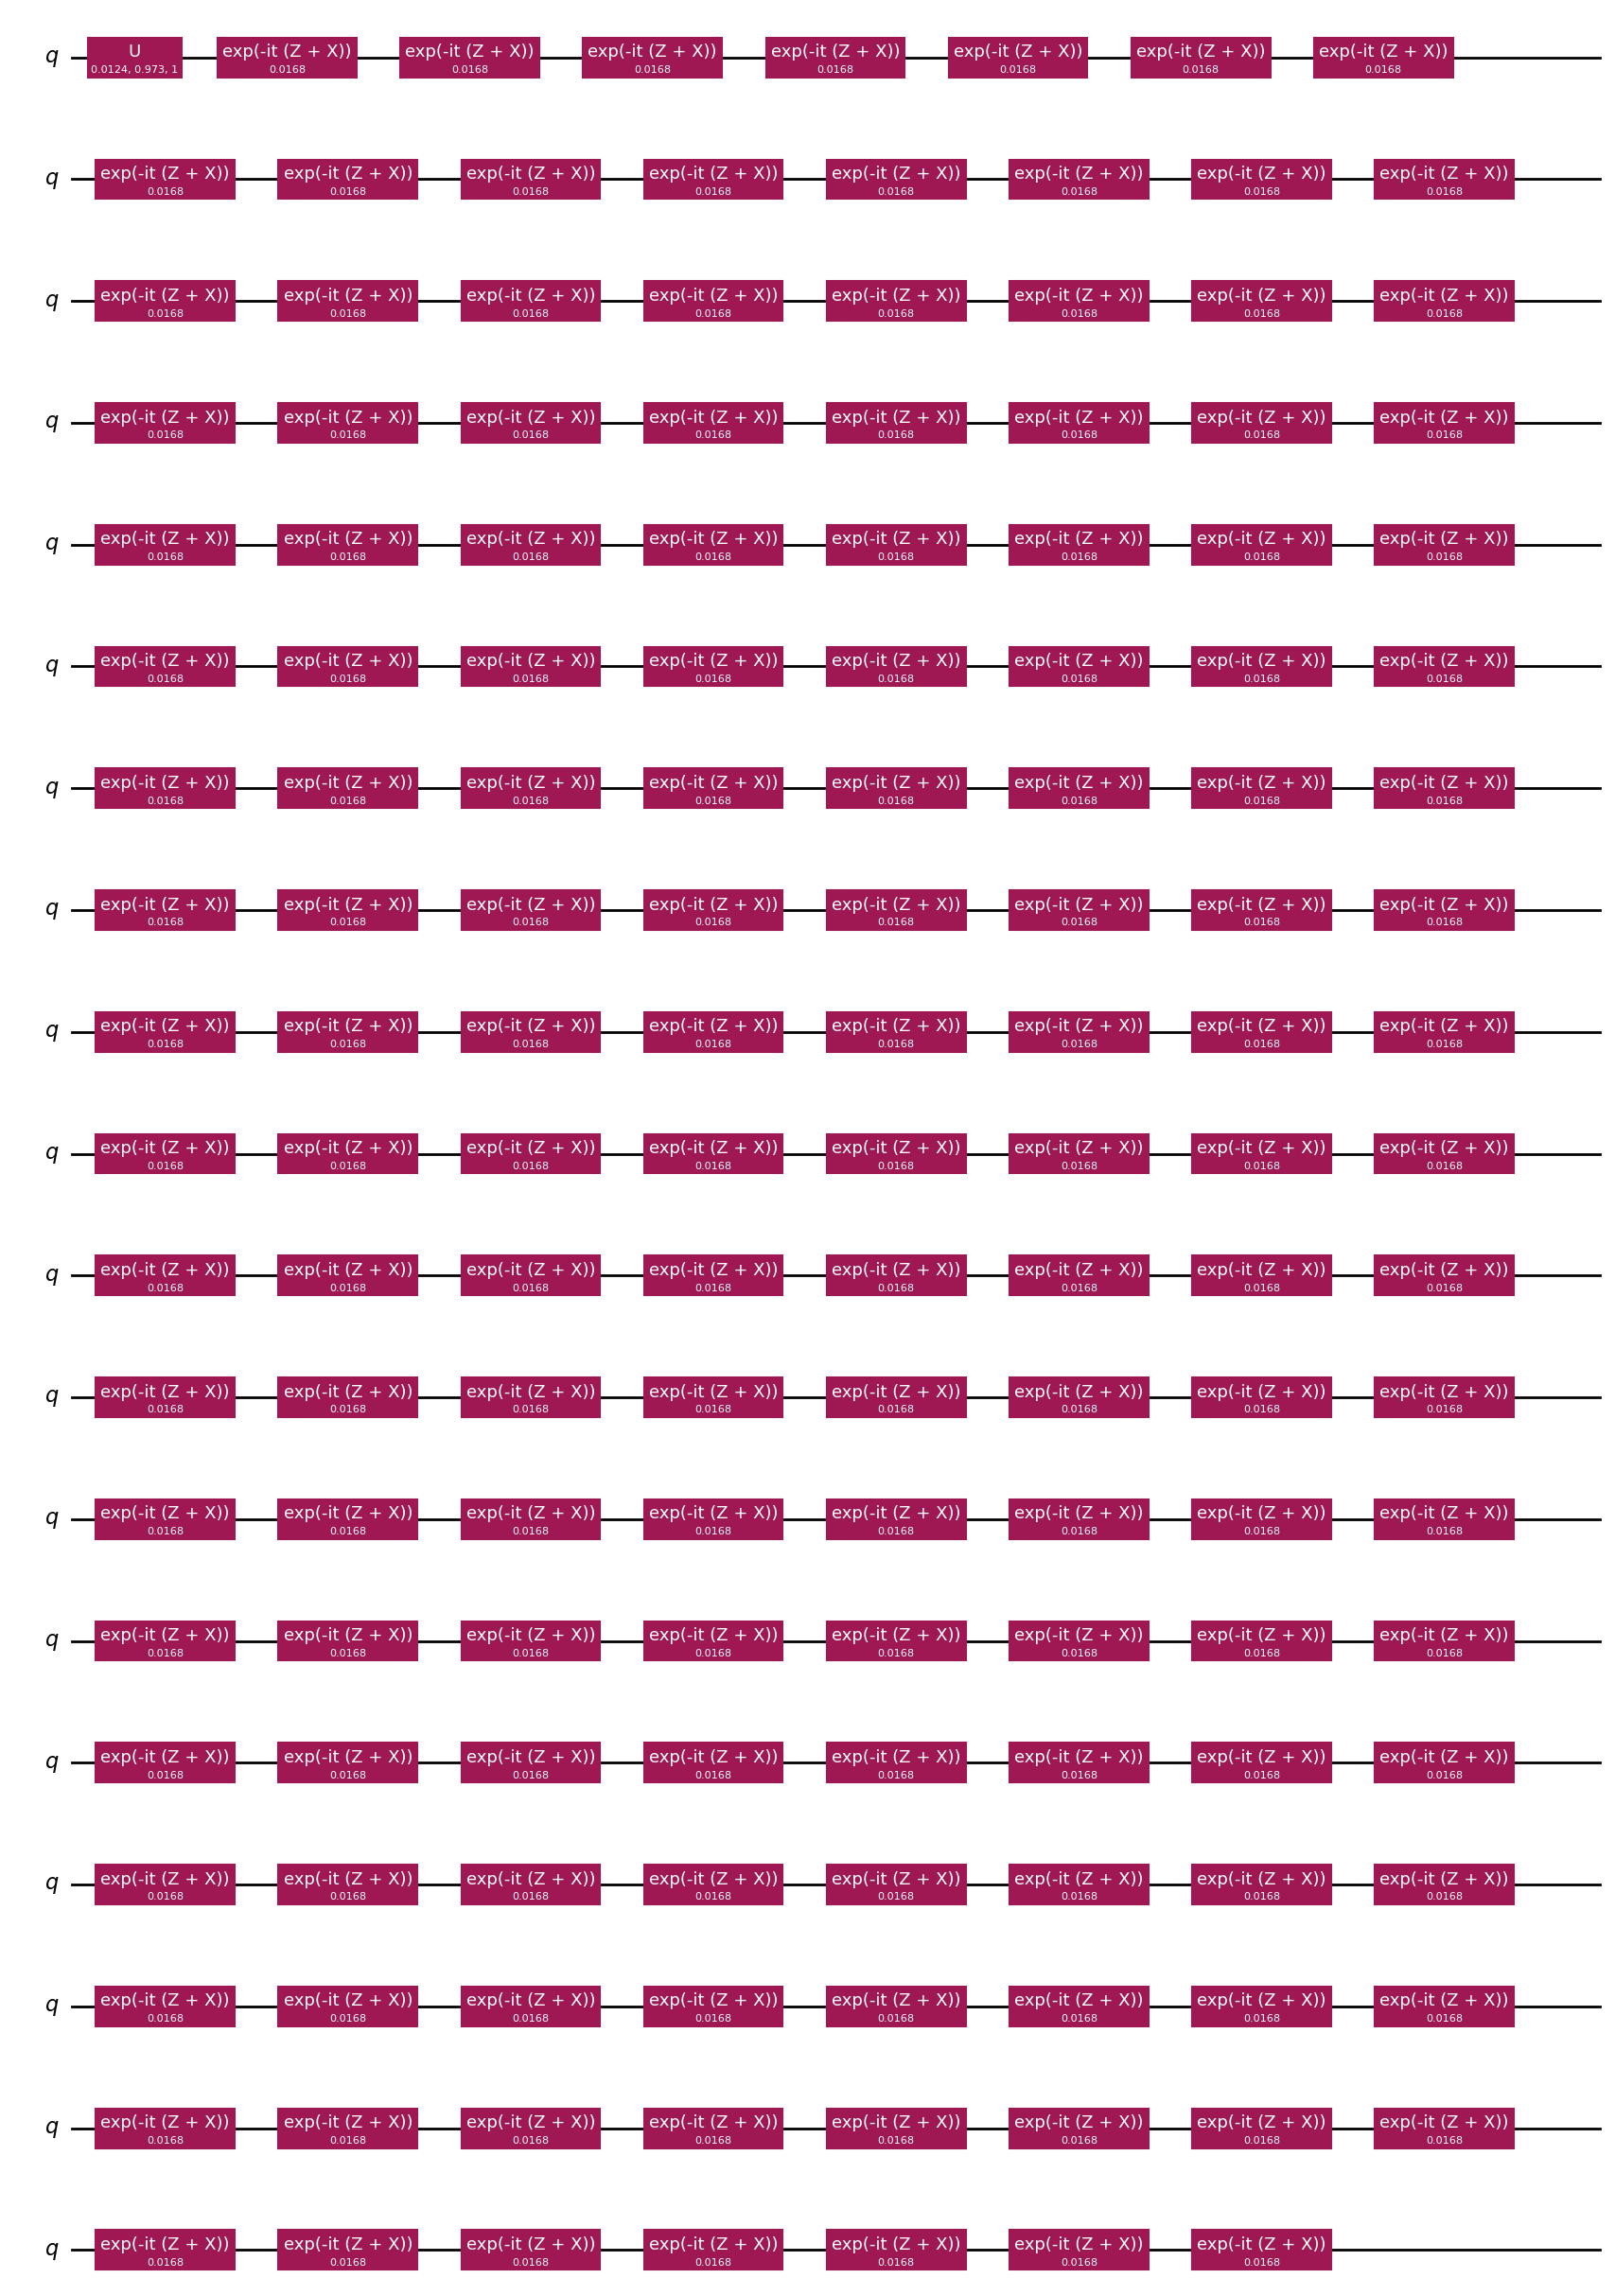

In [30]:
test_qc.assign_parameters(result.x).compose(unitary_timevo_circuit).draw('mpl')

### Spin chain

In [ ]:
print(hamiltonian_linear(0,2))

In [ ]:
qc = QuantumCircuit(chain_length)

# qc.h(qc.qubits)

create_ansatz_circuit(qc)

unitary = unitary_time_evolution(hamiltonian)

qc.compose(unitary, inplace=True)

# qc.measure_all()

# qc.draw('mpl')

# print(time_evolver(qc, hamiltonian(0)))

In [ ]:
dt

### Spin ladder

In [ ]:
qc = QuantumCircuit(chain_length)

ansatz_circuit_ladder(qc, omit_ratio=1/3)